**Goal**: In this notebook we analyse how well the model performs on the TSO500 dataset.

### References
[1]: Donker _et al_., "Decoding circulating tumor DNA to identify durable benefit from immunotherapy in lung cancer." Lung Cancer 170 (2022): 52-57.  
[2]: Donker _et al_., "Using genomic scars to select immunotherapy beneficiaries in advanced non-small cell lung cancer", Scientific Reports (2023).  
[3]: Cuppens _et al_., "HLA-I diversity and tumor mutational burden by comprehensive next-generation sequencing as predictive biomarkers for the treatment of non-small cell lung cancer with PD-(L) 1 inhibitors." Lung Cancer 170 (2022): 1-10.  

## Univariate analysis

In [ ]:
from matplotlib import pyplot as plt
from numpy import arange
from pandas import read_csv


# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

from src.plot import get_y_and_yerr, truncate_signatures

In [ ]:
# Whole genome sequencing mutations from the Discovery dataset of Donker et al., Scientific Reports ('23).
X_hrtw = read_csv("../artifacts/hartwig_wes_signature.tsv", sep="\t", index_col=0)
y_hrtw = X_hrtw.pop("durable_benefit")
not_na_hrtw = ~y_hrtw.isna()

# In silico projection of above dataset onto the TSO500 panel.
X_hrtw_silico = read_csv(
    "../artifacts/hartwig_in_silico_tso500_signature.tsv", sep="\t", index_col=0
)
y_hrtw_silico = X_hrtw_silico.pop("durable_benefit")
not_na_hrtw = ~y_hrtw_silico.isna()

# The TSO500 mutation dataset of Cuppens et al., Lung Cancer ('22).
X_cupp = read_csv("../artifacts/cuppens_signature.tsv", sep="\t", index_col=0)
y_cupp = X_cupp.pop("durable_benefit")


In [ ]:
SBS_columns = [c for c in X_cupp.columns if 'SBS' in c]
# Normalise by panel size.
X_hrtw_silico[SBS_columns] = X_hrtw_silico[SBS_columns].apply(lambda x: x / 1.27)

In [ ]:
# Take same top 10.
X_cupp_top10 = truncate_signatures(X_cupp[SBS_columns], signatures=10)
cols_top10 = X_cupp_top10.columns.tolist()
cols_top10.remove('rest')
X_hrtw_top10 = truncate_signatures(X_hrtw[SBS_columns], signatures=cols_top10)

In [ ]:
def plot_signatures(X_signa, ax, log=True):
    """Plot all but the last column (rest) which is quite large."""
    x_cols = X_signa.columns 
    x_coords = arange(len(x_cols))
    delta = 0.75

    y, _ = get_y_and_yerr(X_signa)
    ax.bar(x_coords, y, width=delta, label='TSO500 (Jessa)')

    if log:
        ax.set_yscale('symlog', linthresh=1/100)
    ax.set_xticks(ticks=x_coords)
    ax.set_xticklabels(x_cols, rotation=90)
    ax.set_ylabel('Signature attribution (Mb${}^{-1}$)')
    ax.set_xlabel('Singlet signature')
    ax.grid(True, which='both')

    return ax

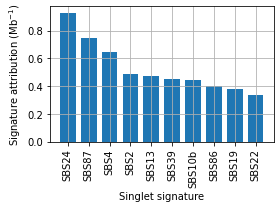

In [ ]:
# Plot 
plt.figure(figsize=(4,3))

plot_signatures(X_cupp_top10.drop(columns='rest'), plt.gca(), log=False)
plt.tight_layout()

plt.savefig('figs/fig_s1_summary_statistics_log_jessa.eps', bbox_inches='tight')
plt.savefig('figs/fig_s1_summary_statistics_log_jessa.svg', bbox_inches='tight')
plt.savefig('figs/fig_s1_summary_statistics_log_jessa.png', bbox_inches='tight')

In [ ]:
X_cupp['SBS1'].describe()[['mean', '25%', '50%', '75%']]

mean    0.256888
25%     0.000000
50%     0.000000
75%     0.000000
Name: SBS1, dtype: float64

In [ ]:
X_cupp['SBS30'].describe()[['mean', '25%', '50%', '75%']]

mean    0.222052
25%     0.000000
50%     0.000000
75%     0.000000
Name: SBS30, dtype: float64

In [ ]:
x_cols = ['SBS4', 'SBS87']

In [ ]:
print('Mean')
print(X_cupp[x_cols].mean())
print()
print('Coefficient of variation:')
print(X_cupp[x_cols].std()/X_cupp[x_cols].mean())
print()
X_cupp[x_cols].quantile([0.25, 0.75])

Mean
SBS4     0.649068
SBS87    0.746548
dtype: float64

Coefficient of variation:
SBS4     3.431186
SBS87    2.062235
dtype: float64



SBS4     SBS87
0.25   0.0  0.000000
0.75   0.0  1.259319

## Classifier performance

In [1]:
import pandas as pd
from pandas import DataFrame, read_csv
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from statkit.distributions import ZeroInflatedExponential
from statkit.metrics import binary_classification_report
from statkit.naive_bayes import NaiveBayesClassifier
from statkit.types import Estimate

/tmp/ipykernel_21213/494391235.py:6: DeprecationWarning: The naive Bayes module is deprecated and will be removed in version 0.2.0.
  from statkit.naive_bayes import NaiveBayesClassifier


In [2]:
X_hrtw = read_csv('../artifacts/hartwig_wes_signature.tsv', sep='\t', index_col=0)
y_hrtw = X_hrtw.pop('durable_benefit')
not_na_hrtw = ~y_hrtw.isna()

X_cupp = read_csv('../artifacts/cuppens_signature.tsv', sep='\t', index_col=0)
y_cupp = X_cupp.pop('durable_benefit')

## Donker et al. classifier validation
Here, we test whether the model of Donker _et al._, Scientific Reports ('23), which was trained on the Hartwig data to see if it generalises to the TSO500 data.

In [3]:
# Prediction threshold based on [1].
# Number of durable benefit:
threshold = 160/365

# Classifier of Donker et al [2].
# Train the classifier (like in [2]) on the Hartwig using these features.
features = ['SBS4', 'SBS87']
clf = NaiveBayesClassifier(ZeroInflatedExponential).fit(X_hrtw.loc[not_na_hrtw, features], y_hrtw[not_na_hrtw])

# And test performance on the Jessa cohort of Cuppens et al. [3].
y_cupp_pred_proba = clf.predict_proba(X_cupp[features]).iloc[:,1]

In [4]:
report = binary_classification_report(y_cupp, y_cupp_pred_proba, threshold=threshold)

metrics_latex = {}
for metric_name, performance in report.iterrows():
    estimate = Estimate(**performance)
    metrics_latex[metric_name] = estimate.latex().replace('$', '')
    print(f'{metric_name}: ', estimate)

pd.Series(metrics_latex).to_clipboard()

Accuracy:  0.51 (95 % CI: 0.42-0.60)
Average precision:  0.52 (95 % CI: 0.43-0.65)
$F_1$:  0.37 (95 % CI: 0.24-0.48)
ROC AUC:  0.50 (95 % CI: 0.41-0.59)
Sensitivity:  0.29 (95 % CI: 0.18-0.41)
Specificity:  0.72 (95 % CI: 0.61-0.83)


In [5]:
# Make a small report to share with the JESSA team.
report = DataFrame(X_cupp[features])
report.loc[:, 'probability durable benefit'] = y_cupp_pred_proba
report['prediction'] = (y_cupp_pred_proba >= threshold).map(lambda x: 'durable benefit' if x else 'non-durable benefit')
report.index = report.index.map(lambda x: x.removeprefix('CUP_'))
report.index.name = 'Sample'
report.to_csv('prediction-report.csv')


It might be that this poor performance is attributable to difference in distributions. 
To rule this out, and indicate whether the drop in model performance relates to model, we train on the Cuppens et al. (TSO500) dataset. 
We analyse how well the model can fit the data using leave-one-out cross validation.

In [6]:
features = ['SBS4', 'SBS87']

clf = NaiveBayesClassifier(ZeroInflatedExponential)
y_cupp_proba = cross_val_predict(
    clf,
    X_cupp[features],
    y_cupp,
    cv=LeaveOneOut(),
    method='predict_proba',
    verbose=1,
)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    0.4s finished


In [7]:
report_lof = binary_classification_report(y_cupp, y_cupp_proba, threshold=threshold)

metrics_lof = {}
for metric_name, performance in report_lof.iterrows():
    estimate = Estimate(**performance)
    metrics_lof[metric_name] = estimate.latex().replace('$', '')
    print(f'{metric_name}: ', estimate)

pd.Series(metrics_lof).to_clipboard()

Accuracy:  0.30 (95 % CI: 0.22-0.38)
Average precision:  0.53 (95 % CI: 0.42-0.65)
$F_1$:  0.33 (95 % CI: 0.22-0.43)
ROC AUC:  0.44 (95 % CI: 0.33-0.55)
Sensitivity:  0.35 (95 % CI: 0.23-0.48)
Specificity:  0.25 (95 % CI: 0.15-0.36)
